In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
ticker = "NVDA"
df = yf.download(ticker, start='2025-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


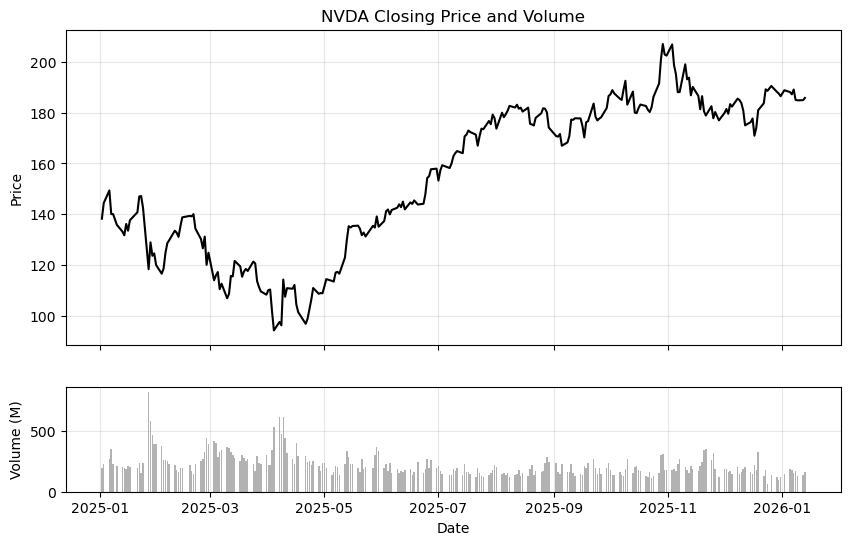

In [3]:
# Plot 
fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 6), sharex=True)
ax1, ax2 = axes

# Plot stock price
ax1.plot(df.index, df['Close'], color='black')
ax1.set_title(f'{ticker} Closing Price and Volume')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# Plot volume (bar plot/histogram) on the bottom
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return f'{x/1e6:.0f}' # format to one decimal place
    
ax2.bar(df.index, df['Volume'].values.ravel(), color='grey', alpha=0.6)
ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.set_ylabel("Volume (M)")
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

#plt.xticks(rotation=45)
plt.show()

In [4]:
# On-Balance Volume (OBV)
# It is a indicator that measures cumulative volume flow. 
# OBV(t) = OBV(t-1) + Volume(t) if Close(t) > Close(t-1), else -Volume(t).

def calculate_obv(df: pd.DataFrame) -> pd.Series:
    """ 
    Parameters:
    - df: DataFrame with 'Close', 'Volume'.
    
    Returns:
    - Series with OBV values.
    
    Interpretation: Rising OBV confirms uptrend (buying pressure is up); divergences signal weakness.
    """
    required_cols = ['Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns: Close, Volume.")
    if len(df) < 2:
        raise ValueError("DataFrame must have at least 2 rows.")
    
    obv = pd.Series(0, index=df.index, dtype=float)
    for i in range(1, len(df)):
        if df['Close'].iloc[i].item() > df['Close'].iloc[i-1].item():
            obv.iloc[i] = obv.iloc[i-1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i].item() < df['Close'].iloc[i-1].item():
            obv.iloc[i] = obv.iloc[i-1] - df['Volume'].iloc[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    return obv
    

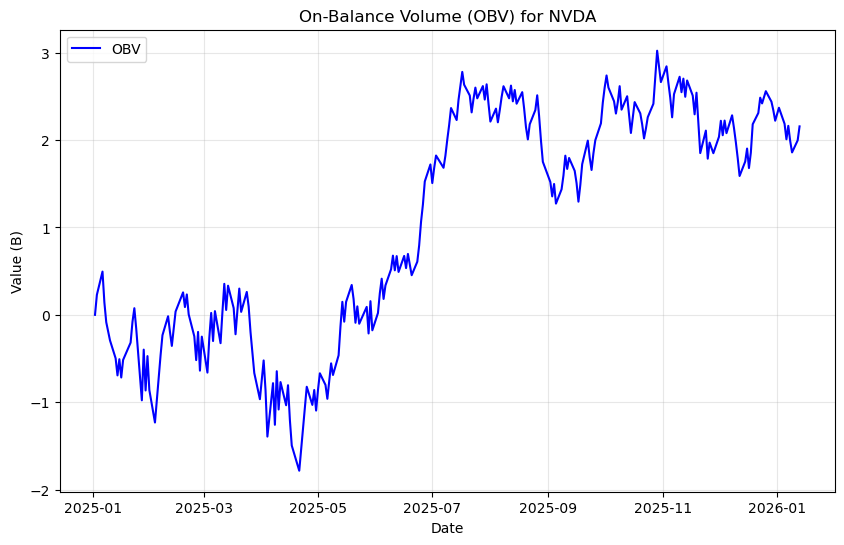

In [5]:
# Example (OBV)

OBV = calculate_obv(df)

plt.figure(figsize=(10, 6))
plt.plot(df.index, OBV/1e9, label='OBV', color='blue')
plt.ylabel('Value (B)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.title(f'On-Balance Volume (OBV) for {ticker}')
plt.show()

In [6]:
# Chaikin Money Flow (CMF)
# CMF = Sum(MFM x Volume) / Sum(Volume) over period, where 
# the Money Flow Multiplier (MFM) = ((Close - Low) - (High - Close)) / (High - Low) measures buying and selling pressures. 

def calculate_cmf(df: pd.DataFrame, period: int = 21) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close', 'Volume'.
    - period: window size (default 21).
    
    Returns:
    - Series with CMF values (-1 to 1).
    
    Interpretation: >0 buying pressure; <0 selling. Use for accumulation/distribution.
    """
    required_cols = ['High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    mfm = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfm * df['Volume']
    cmf = mfv.rolling(window=period).sum() / df['Volume'].rolling(window=period).sum()
    
    return cmf
    

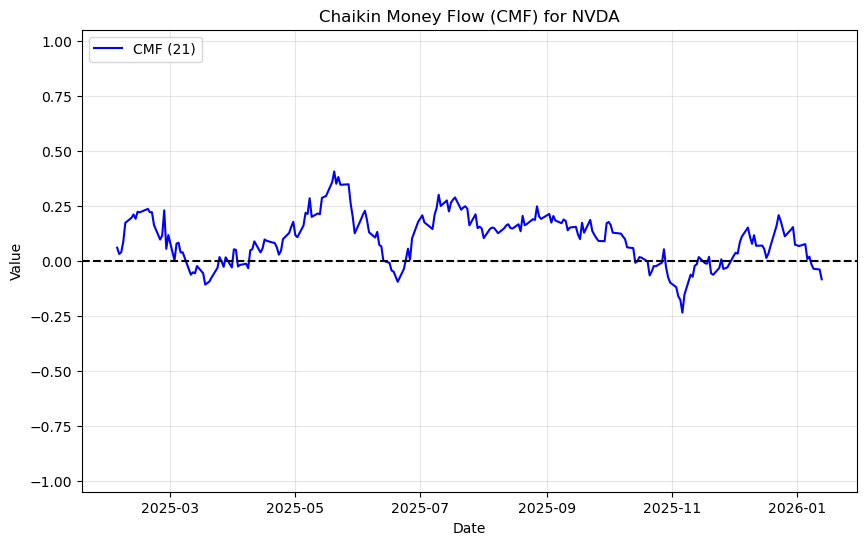

In [7]:
# Example (CMF)

cmf_period = 21
CMF = calculate_cmf(df, cmf_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, CMF, label=f'CMF ({cmf_period})', color='blue', linewidth=1.5)
plt.ylim(-1.05, 1.05)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(0, color='black', linestyle='--', label='Zero line')

plt.title(f'Chaikin Money Flow (CMF) for {ticker}')
plt.show()

In [8]:
# Accumulation/Distribution Line (ADL)
# A/D(t) = A/D(t-1) + Volume x ((Close - Low) - (High - Close)) / (High - Low).

def calculate_ad_line(df: pd.DataFrame) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close', 'Volume'.
    
    Returns:
    - Series with A/D values.
    
    Interpretation: rising A/D confirms accumulation; use with price for divergences.
    """
    required_cols = ['High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < 2:
        raise ValueError("DataFrame must have at least 2 rows.")
    
    mfm = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) # Money Flow Multiplier
    ad = mfm * df['Volume']
    ad_line = ad.cumsum()
    
    return ad_line

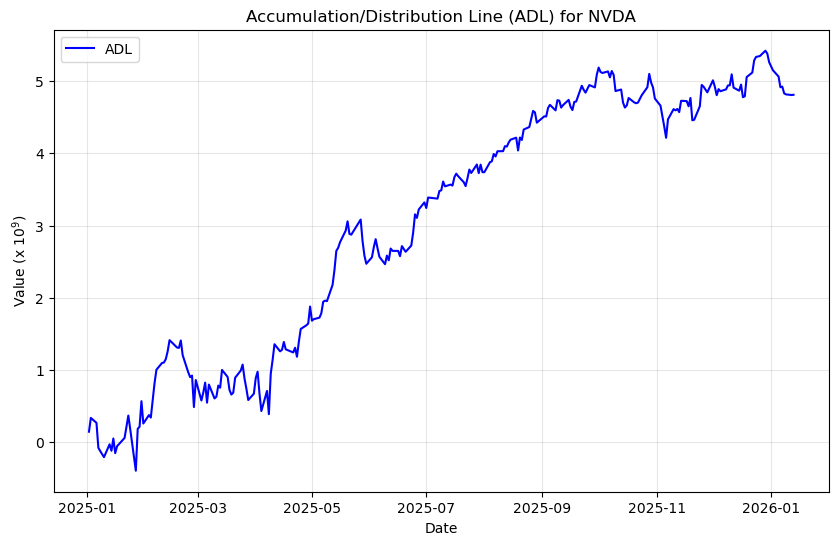

In [9]:
# Example (ADL)

ADL = calculate_ad_line(df)

plt.figure(figsize=(10, 6))
plt.plot(df.index, ADL/1e9, label=f'ADL', color='blue', linewidth=1.5)
plt.ylabel('Value (x $10^9$)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.title(f'Accumulation/Distribution Line (ADL) for {ticker}')
plt.show()